In [1019]:
#### A step by step explanation of backpropagation and training of neural networks. Follows a video by Andrej Karpathy found here: https://youtu.be/VMj-3S1tku0

In [1020]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

### How a derivative works

In [1021]:
def f(x):
    return 3*x**2 - 4*x + 5

In [1022]:
f(3.0)

20.0

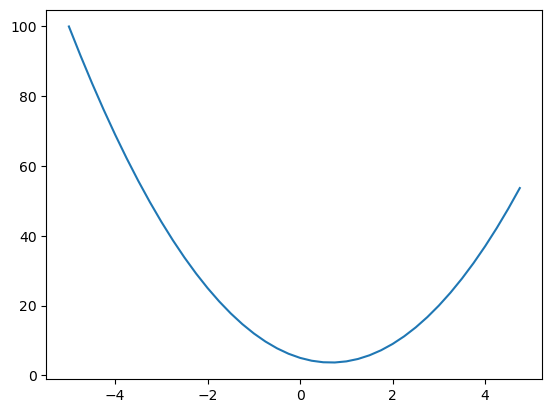

In [1023]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [1024]:
h = 0.00001
x = 2/3
(f(x+h) - f(x))/h

3.0000002482211127e-05

In [1025]:
# Get more complex
a = 2.0
b = -3.0
c = 18.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)

d1 12.0
d2 11.99997


## Value class

In [1026]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad}, label={self.label})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only supports int and float exponents"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
        
    def __neg__(self):
        return self * -1
    
    def __radd__(self, other):
        return self + other
    
    def __sub__(self, other):
        return self + (-other)

    def __truediv__(self, other):
        return self * (other ** -1)

    def __rtruediv__(self, other):
        return other * (self ** -1)
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        
        out._backward = _backward

        return out
    
    def backward(self):

        topo = []
        visited = set()
        def topo_sort(node):
            if node not in visited:
                visited.add(node)
                for child in node._prev:
                    topo_sort(child)
                topo.append(node)
        topo_sort(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
                   
# a = Value(2.0, label='a')
# b = Value(-3.0, label='b')
# c = Value(10.0, label='c')
# e = a*b; e.label='e'
# d = e + c; d.label='d'
# d
# f = Value(-2.0, label='f')
# L = d * f; L.label='L'
# L
   

In [1027]:
from graphviz import Digraph

def trace(root):
    # Builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(node):
        if node not in nodes:
            nodes.add(node)
            for child in node._prev:
                edges.add((child, node))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # For any value in the graph, create a rectangular ("record") node for it
        dot.node(name = uid, label = f"{n.label} | data {n.data:.4f} | grad {n.grad:.4f}", shape='record')
        if n._op:
            # If this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # Connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

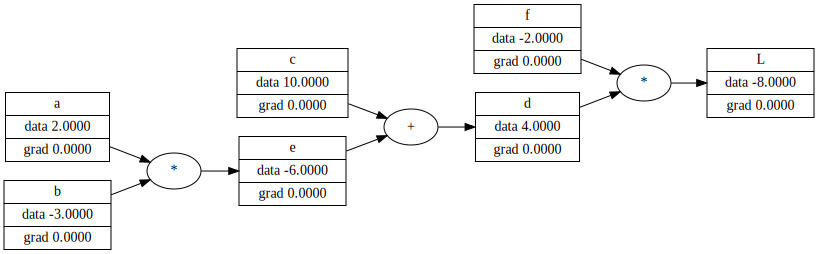

In [1028]:
draw_dot(L)

### Manual backpropagation

In [1029]:
def lol():
    
    h = 0.00001    

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    b.data += h
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L.data

    print((L2 - L1)/h)

lol()

-4.000000000026205


In [1030]:
# L.grad = 1.0
# draw_dot(L)

#### How to find the derivative of L relative to d

L = d * f

dL / dd =? f

dL / df =? d

(f(x+h)) - f(x)) / h

((d+h)*f - d*f) / h

(d*f + h*f - d*f) / h

(h*f) / h

f

In [1031]:
# f.grad = 4.0
# d.grad = -2.0
# draw_dot(L)

#### How to find the derivative of c and e relative to d

dd / dc =? 1.0

dd / de =? 1.0

d = c + e

f(x+h) - f(x) / h

((c+h + e) - (c + e)) / h

(c + h + e - c -e) / h

h/h

1.0

#### How to find dL / dc

WANT: 

dL / dc = (dL / dd) * (dd / dc) # chain rule

so, dL / dc = f * 1.0 = f

and, dL / de = f * 1.0 = f

KNOW: 

dL / dd = f

dd / dc = 1.0

In [1032]:
# c.grad = -2.0
# e.grad = -2.0
# draw_dot(L)

KNOW: 

dL / de = -2.0

e = a * b

de / da =? b

WANT:

dL / da = (dL / de) * (de / da) # chain rule

so, dL / da = -2.0 * -3.0 = 6.0

and, dL / db = -2.0 * 2.0 = -4.0

In [1033]:
# a.grad = 6.0
# b.grad = -4.0
# draw_dot(L)

### Manual backpropagation through a neuron

In [1034]:
# a.data += 0.01 * a.grad
# b.data += 0.01 * b.grad
# c.data += 0.01 * c.grad
# f.data += 0.01 * f.grad

# e = a * b
# d = e + c
# L = d * f

# print(L.data)

In [1035]:
# # inputs x1, x2
# x1 = Value(2.0, label='x1')
# x2 = Value(0.0, label='x2')

# # weights w1, w2
# w1 = Value(-3.0, label='w1')
# w2 = Value(1.0, label='w2')

# # bias of the neuron
# b = Value(6.8813735870195432, label='b')

# # x1*w1 + x2*w2 + b
# x1w1 = x1 * w1; x1w1.label='x1w1'
# x2w2 = x2 * w2; x2w2.label='x2w2'
# x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
# n = x1w1x2w2 + b; n.label='n'
# o = n.tanh(); o.label='o'
# draw_dot(o)

In [1036]:
# o.grad = 1.0
# draw_dot(o)

o = tanh(n)

do/dn = 1 - tanh(n)^2 = 1 - o^2

In [1037]:
# 1 - o.data**2

In [1038]:
# n.grad = 0.5
# draw_dot(o)

In [1039]:
## x1w1 + x2w2 + b = n, so
# x1w1x2w2.grad = 0.5
# b.grad = 0.5
# draw_dot(o)

In [1040]:
# x1w1 + x2w2 = x1w1x2w2, so
# x1w1.grad = 0.5
# x2w2.grad = 0.5
# draw_dot(o)

In [1041]:
# x1.grad = w1.data * x1w1.grad
# w1.grad = x1.data * x1w1.grad
# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad
# draw_dot(o)

#### Implementing the backwards function

In [1042]:
# # inputs x1, x2
# x1 = Value(2.0, label='x1')
# x2 = Value(0.0, label='x2')

# # weights w1, w2
# w1 = Value(-3.0, label='w1')
# w2 = Value(1.0, label='w2')

# # bias of the neuron
# b = Value(6.8813735870195432, label='b')

# # x1*w1 + x2*w2 + b
# x1w1 = x1 * w1; x1w1.label='x1w1'
# x2w2 = x2 * w2; x2w2.label='x2w2'
# x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
# n = x1w1x2w2 + b; n.label='n'
# o = n.tanh(); o.label='o'
# draw_dot(o)

In [1043]:
# o.grad = 1.0
# o._backward()
# draw_dot(o)

In [1044]:
# n._backward()
# draw_dot(o)

In [1045]:
# b._backward()

In [1046]:
# x1w1x2w2._backward()
# x1w1._backward()
# x2w2._backward()
# draw_dot(o)

In [1047]:
# topo = []
# visited = set()
# def topo_sort(node):
#     if node not in visited:
#         visited.add(node)
#         for child in node._prev:
#             topo_sort(child)
#         topo.append(node)
# topo_sort(o)
# topo

# for node in reversed(topo):
#     node._backward()

<!-- # inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'
draw_dot(o) -->

In [1048]:
# draw_dot(o)

In [1049]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'
o.backward()

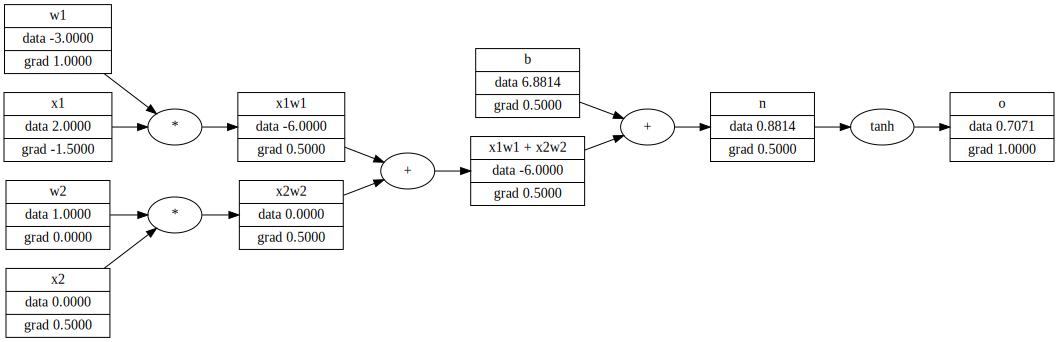

In [1050]:
draw_dot(o)

In [1051]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label='x1*w1'
x2w2 = x2 * w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'
#-------------------
e = (2 * n).exp()
o = (e - 1) / (e + 1)
#-------------------
o.label = 'o'
o.backward()

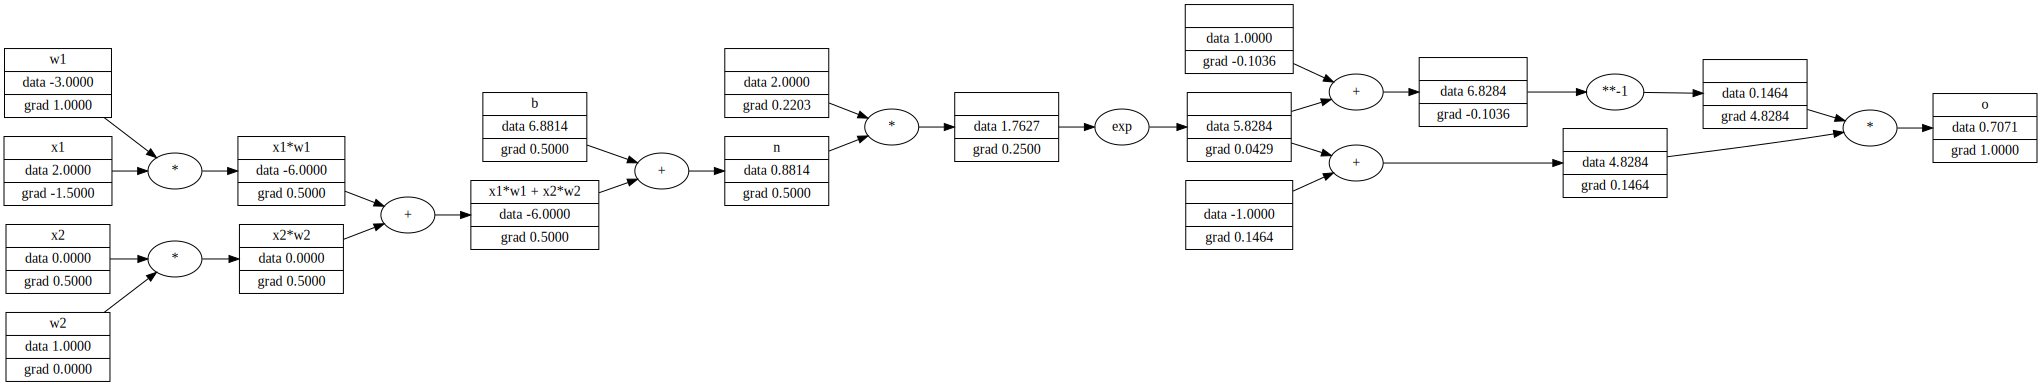

In [1052]:
draw_dot(o)

#### Do the same thing, but in PyTorch

In [1053]:
import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("------------------")
print("x2", x2.grad.item())
print("w2", w2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())

0.7071066904050358
------------------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


## Building a neural net in micrograd

In [1054]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]
    
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [1070]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.772762804366736, grad=0, label=)

In [1056]:
n.parameters()

[Value(data=-0.04728632236996888, grad=0, label=),
 Value(data=-0.8696046572273539, grad=0, label=),
 Value(data=-0.111654441308217, grad=0, label=),
 Value(data=0.7268733615848355, grad=0, label=),
 Value(data=0.6833634074011647, grad=0, label=),
 Value(data=0.7144271515437015, grad=0, label=),
 Value(data=-0.31568818204692284, grad=0, label=),
 Value(data=-0.5273159884338561, grad=0, label=),
 Value(data=-0.45265490784816387, grad=0, label=),
 Value(data=-0.14419273018285783, grad=0, label=),
 Value(data=-0.23908812552213865, grad=0, label=),
 Value(data=-0.8973897349760538, grad=0, label=),
 Value(data=0.8401694533305948, grad=0, label=),
 Value(data=0.810435434519398, grad=0, label=),
 Value(data=0.5292038716914045, grad=0, label=),
 Value(data=-0.885405017801546, grad=0, label=),
 Value(data=0.7813900096586068, grad=0, label=),
 Value(data=-0.8641879994597763, grad=0, label=),
 Value(data=-0.5007745778949655, grad=0, label=),
 Value(data=-0.43944386682079717, grad=0, label=),
 Val

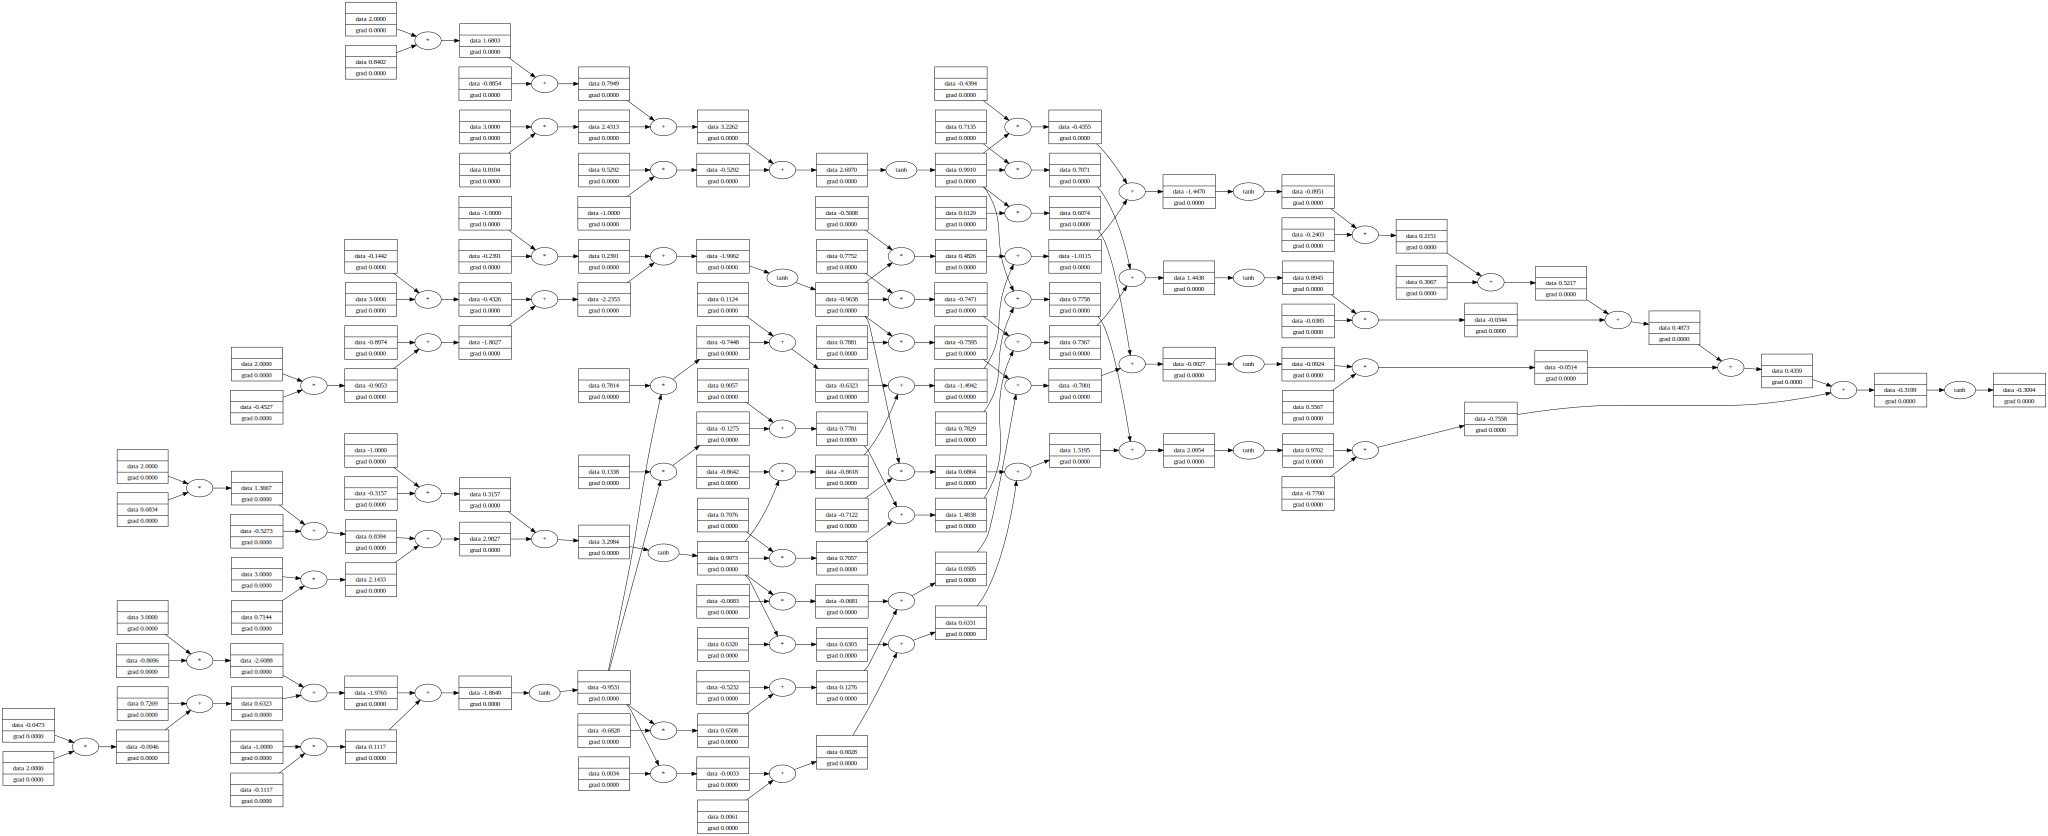

In [1057]:
draw_dot(n(x))

In [1071]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [1090]:
for k in range(20):
    
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update parameters
    for p in n.parameters():
        p.data -= 0.05 * p.grad
    
    print(k, loss.data)

0 0.002293172108145433
1 0.0022859352880924048
2 0.0022787428392031885
3 0.0022715943590747856
4 0.0022644894501253157
5 0.002257427719522331
6 0.0022504087791124492
7 0.002243432245352038
8 0.002236497739239416
9 0.0022296048862479826
10 0.002222753316260673
11 0.00221594266350555
12 0.002209172566492345
13 0.0022024426679504387
14 0.0021957526147675707
15 0.0021891020579297912
16 0.002182490652462466
17 0.002175918057372162
18 0.0021693839355896617
19 0.002162887953913934


In [1091]:
ypred

[Value(data=0.9831297923462538, grad=-0.0337404153074925, label=),
 Value(data=-0.9742613879822039, grad=0.051477224035592295, label=),
 Value(data=-0.9817495975664503, grad=0.03650080486709939, label=),
 Value(data=0.9702892155935886, grad=-0.05942156881282279, label=)]

In [1060]:
# loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))
# loss

In [1061]:
# loss.backward()

In [1062]:
# n.layers[0].neurons[0].w[0].grad

In [1063]:
# n.layers[0].neurons[0].w[0].data

In [1064]:
# draw_dot(loss)

In [1065]:
# for p in n.parameters():
#         p.data -= 0.01 * p.grad

In [1066]:
# n.layers[0].neurons[0].w[0].data

In [1067]:
# loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))
# loss

In [1068]:
# loss goes down
# ypred = [n(x) for x in xs]
# loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))
# loss

In [1069]:
# ypred